In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib.animation import FuncAnimation
from scipy.linalg import eig
from ffmpeg import *
import sys

In [2]:
# définitions des variables physique et de simulation
nx = 100
DT = 1/nx**2
t_end = 10

K = 5/nx
V = 0

DIFF = 1
CONV = 0

ANIM = 1

CFL_DIFF = 2*K*DT*(nx**2)
CFL_CONV = 0

In [3]:
# Fonctions
def matDiff(nx,CFLdiff) :
    A =np.zeros([nx,nx])
    fac = CFLdiff/2
    for i in range(nx):
        for j in range(nx):
            if i==j :
                A[i,j] = - 2*fac
            elif j == i-1 or j==i+1 :
                A[i,j] = fac
    #conditions aux limites : flux nul
    A[0,-1] =   fac
    A[nx-1,0] =   fac
    return A

def matAConv(nx,CFLconv) :
    A = -np.identity(nx)
    for i in range(nx):
        for j in range(nx):
            if j==i+1 :
                A[i,j] = 1
    # A[0,0]=0
    A[nx-1,0]=1
    A= -A*CFLconv

    return A

def matA(nx,CFLdiff,CFLconv,diff=True,conv=False):
    Id = np.identity(nx)
    if diff and conv :
        A = Id + matAConv(nx,CFLconv) + matDiff(nx,CFLdiff)
    elif diff :
        A = Id + matDiff(nx,CFLdiff)
    elif conv :
        A = Id + matAConv(nx,CFLconv)
    return A

def gaussian(x, mean, std):
    return np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)

def initial_conditions(nx):
    # Define initial conditions
    x = np.linspace(0, 1, nx)
    return gaussian(x,0.5,0.05)

def step(U,A) :
    
    return np.dot(A,U)

def solve(nx,K, t_end, dt,diff=False,conv = True):
    # Initialize grid and initial conditions
    x = np.linspace(0, 1, nx)
    dx = 1/nx
    matU = np.zeros([int(t_end//dt)+3,nx])
    matU[0] = initial_conditions(nx)
    
    CFLdiff = 2*K*dt/(dx**2)
    CFLconv = dt/dx*V
    
    
    A = matA(nx,CFLdiff,CFLconv,diff,conv)
    
    t = 0.0
    i = 0
    while t < t_end:

        u_new = step(matU[i],A)
        matU[i+1,:] = u_new.copy()
        t += dt
        i += 1

    return matU

def plot_solution(x, u,leg=None):
    plt.plot(x, u,label=leg)
    plt.xlabel('x')
    plt.ylabel('u')
    plt.legend()


def spectre(nx,dt,CFLdiff,CFLconv,plot=False,diff=True,conv=False,label = None) :
    # B est la matrice telle que  dU/dt = B*U
    B = (matA(nx, CFLdiff,CFLconv,diff,conv) - np.identity(nx))/dt
    # A_inv = np.linalg.inv(A)
    l,v = eig(B)
    l=l/max(initial_conditions(nx))
    v=v/max(initial_conditions(nx))

    if plot :
        plt.plot(l.real, l.imag, 'o', markersize=6,label = label)
        plt.hlines(y=0.0, xmin=-2, xmax=2, color='k', linestyle='--')
        plt.xlabel('$\omega_r$')
        plt.ylabel('$\omega_i$')
        plt.gca().yaxis.label.set(rotation='horizontal', ha='right');
        plt.title('Spectrum')
    return l,v

def spectreStab(nx,dt,cfl,diff=True,conv=False):
    dtref = 1/nx/K
    # B est la matrice telle que  dU/dt = B*U
    B = (matA(nx, CFL_DIFF,CFL_CONV,diff,conv) - np.identity(nx))/dt
    val, vec = eig(B)
    from scipy.optimize import fsolve
    
    # def maxgain(cfl):
    #     return np.max(abs(integrator(val*cfl*dtref)))-1.001
    # cflmax = fsolve(maxgain, 10)
    # print("cfl max is {}".format(cflmax))

    # display 
    fig=plt.figure()
    plt.scatter(val.real, val.imag)
    dt = cfl*dtref
    x = np.r_[-4:.25:30j]/dtref
    y = np.r_[-3:3:60j]/dtref
    X, Y = np.meshgrid(x, y)
    vp = X+Y*1j
    plt.contour(X,Y,abs(integrator(dt*vp)), levels=[1], linewidths=3, colors='darkorange') # contour() accepts complex values
    plt.axis('equal')
    plt.xlabel('$\omega_r$')
    plt.ylabel('$\omega_i$')
    plt.show()
    return None

def integrator(dt):
    return 1.+ dt 

def findLim() :
    k = np.linspace(0,500)
    y = [0.5]
    nx = 10
    while max(y)<=1 :
        nx = int(nx*1.1)
        y = np.abs(1 - CONV * V*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 2*K*DT*nx**2*np.sin(k/nx/2)**2)
    matSol = solve(nx,K,t_end,DT,DIFF,CONV)
    # anim(solve(nx,K,t_end,DT,DIFF,CONV))
    plt.plot(k,y)
    plt.show()
    print(nx)

def anim(matSol) :
    x = np.linspace(0,1,nx)
    t = np.linspace(0,t_end,int(t_end//DT))
    fig = plt.figure() # initialise la figure
    line, = plt.plot([], []) 
    plt.xlim(0, 1)
    plt.ylim(-1, max(matSol[0]*1.1))

    def animate(i): 
        t = i * DT
        y = matSol[i]
        line.set_data(x, y)
        return line,
    
    ani = FuncAnimation(fig, animate, frames=len(matSol),
                                interval=10, blit=True, repeat=False)
    ani.save('animation.gif',fps=15)
    plt.show()

# def sci(nb,cs) :
#     i=0
#     if nb>1 :
#         exposant = int(nb//10)
#         C = str(nb)[:cs+1]
#     else :
#         exposant = -int(10//nb)
#         nb = str(nb)
#         while nb[i]=='0':
#             i+=1
#         C= nb[i:i+cs]
#     return(C+'e'+str(exposant))
# sci(0.0001256,2)
# sci(4353,2)


simulation stable


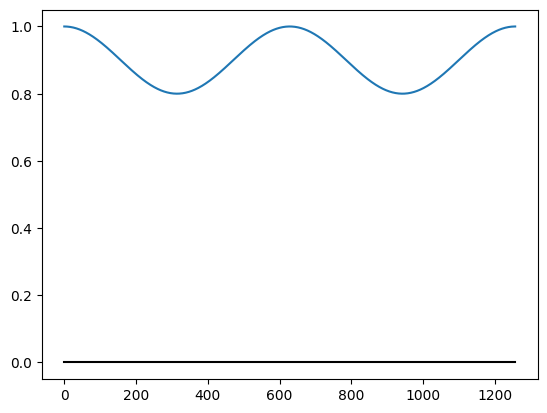

A_{n+1}/A_{n} =  1.0


In [4]:
# critère de stabilité

k = np.linspace(0,4*np.pi*nx,1000)
if DIFF and CONV and     V<K*nx and DT*nx*(K*nx-V)<1:
    print('simulation stable')
    

if DIFF and CONV :
    print('-2K/dx + V + dx/dt = ', -2*K*nx + V + (nx*DT)**(-1))
    print('1 - dt/dx*(2K/dx - V) = ',1 - DT*nx*(2*K*nx - V))
    
elif DIFF and 2*K*DT*nx**2 < 1 :
    print('simulation stable')

elif CONV :
    print('simulation instable')

y = np.abs(1 - CONV * V*DT*nx*( np.exp(1j * k/nx) - 1) - DIFF * 4*K*DT*nx**2*np.sin(k/nx/2)**2)

plt.plot(k,np.zeros(len(k)),'k-')
plt.plot(k,y)
plt.show()
print('A_{n+1}/A_{n} = ',max(y))

if max(y)>1 :
        print('simulation numérique instable')
        sys.exit()



Text(0.5, 1.0, 'K=0.05  V=0  dt=0.000  dx=0.01')

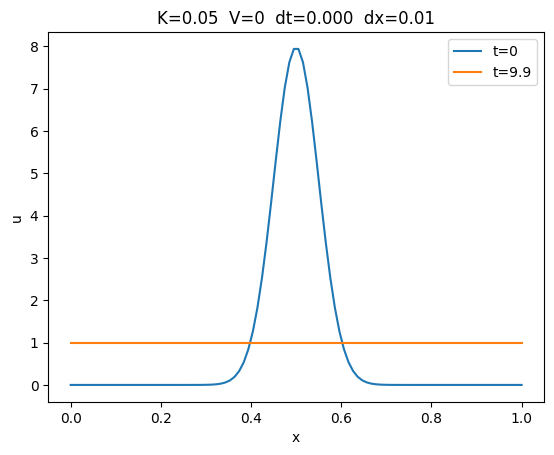

In [5]:
# résolution
matSol = solve(nx, K, t_end, DT,DIFF,CONV)
x = np.linspace(0,1,nx)
t2 = int(t_end//DT - 5)
plot_solution(np.linspace(0, 1, nx),matSol[0],'t=0')
plot_solution(np.linspace(0, 1, nx),matSol[t2],'t='+str(t2*DT)[:3])
plt.title('K='+str(K)[:5]+'  V='+str(V)[:3]+'  dt='+str(DT)[:5]+'  dx='+str(1/nx)[:5])


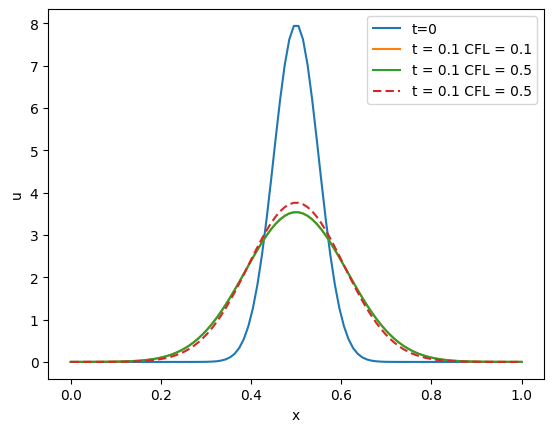

In [6]:
#comparaison des CFL pour diffusion pure
fig, ax = plt.subplots()
matSol = solve(nx, K, t_end, DT,DIFF,CONV)
x = np.linspace(0,1,nx)
plot_solution(np.linspace(0, 1, nx),matSol[0],'t=0')
plot_solution(np.linspace(0, 1, nx),matSol[1000],'t = ' + str(1000*DT) + ' CFL = ' + str(CFL_DIFF))

matSol = solve(nx, K, t_end, 5*DT,DIFF,CONV)
plot_solution(np.linspace(0, 1, nx),matSol[200],'t = ' + str(200*5*DT) + ' CFL = ' + str(10*K*DT*(nx**2)))

fac = 5.7
matSol = solve(nx, K, t_end, fac*DT,DIFF,CONV)
ax.plot(np.linspace(0, 1, nx), matSol[150], dashes=[4, 2],label='t = ' + str(182*fac*DT)[:3] + ' CFL = ' + str(2*fac*K*DT*(nx**2))[:3])
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


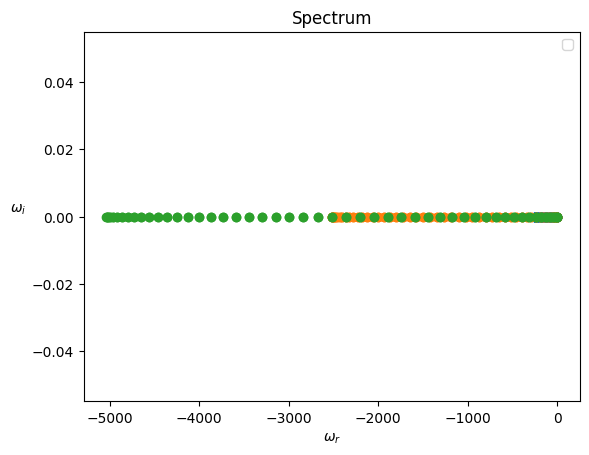

In [7]:
#analyse du spectre dans un cas diffuion pure ou convection pure
for CFL in [0.1,1,2] :
    spectre(nx,DT,CFL,CFL,True,DIFF,CONV)
    # plt.xlim([0.95,1.05])
plt.legend()
plt.show()

# plt.axis('square')
# plt.axis([0.1, 1, -2, 0.5])


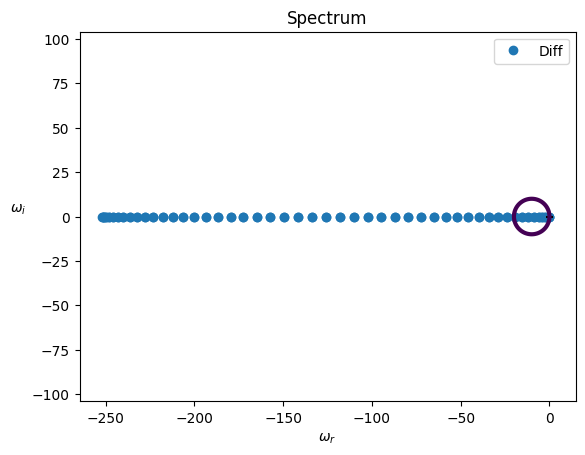

In [8]:
# tracé du spectre étudié
CFLdiff = 2*K*DT*nx**2
CFLconv = DT*nx*V
spectre(nx,DT,CFLdiff,CFLconv,True*DIFF*CONV,1,1,label='Diff + Conv')
spectre(nx,DT,CFLdiff,0,1*DIFF,1,0,label='Diff')
spectre(nx,DT,0,CFLconv,CONV,0,1,label='Conv')
# plt.xlim([0.95,1.05])
def integrator1(dt):
    return 1.+ dt 

dtref = 1 ; DT = 0.1*dtref

x = np.r_[-40:.25:60j]/dtref
y = np.r_[-30:30:120j]/dtref
X, Y = np.meshgrid(x, y)
vp = X+Y*1j
plt.contour(X,Y,abs(integrator1(DT*vp)), levels=[1], linewidths=3) # contour() accepts complex values
plt.axis('equal')

plt.legend()
plt.show()

Pour la stabilité, on trouve par l'analyse qu'il faut ,$\forall k$, $$ \displaystyle\left\lvert 1- 4*\frac{K*dt}{dx^2}* sin^2(k*dx/2) \right\rvert < 1$$ 
On définit donc le CFL de la manière suivante : $$CFL = 2*\frac{K*dt}{dx^2} $$

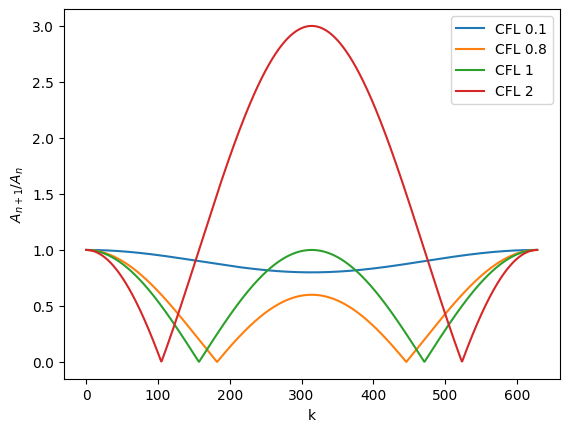

In [9]:
#Tracé de la stabilité en fonction des fréquences spatiales et du CFL
T= 2*nx*np.pi
k = np.linspace(0,T,1000)

for CFL in [0.1,0.8,1,2] :
    y = np.abs(1-2*CFL* (np.sin(k/(2*nx))**2))
    plt.plot(k,y,label = 'CFL ' + str(CFL))

plt.xlabel('k')
plt.ylabel('$A_{n+1}/A_n$')
plt.legend()
plt.show()



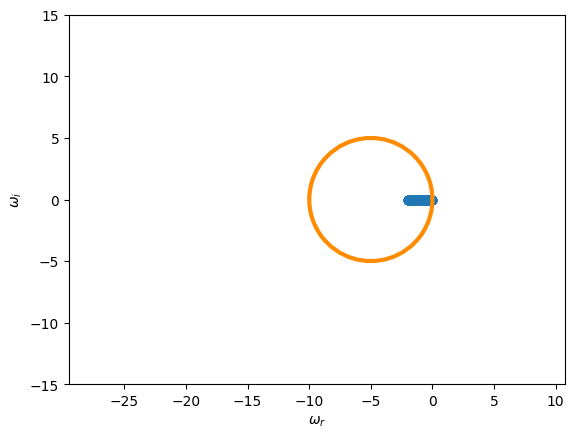

In [10]:
spectreStab(nx,DT,1,DIFF,CONV)


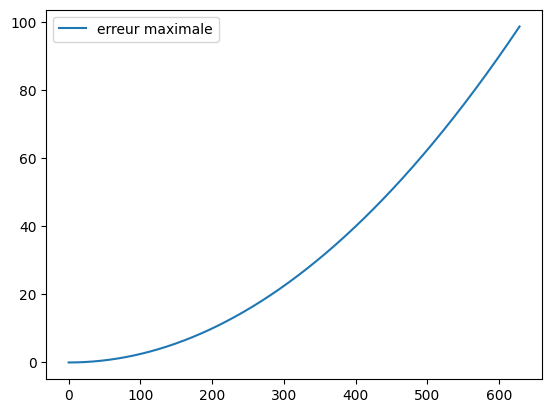

In [11]:
#estimation de l'erreur
N=30
y=np.zeros(N)
CFLs = np.linspace(0.01,5,N)
k = np.linspace(0,T,1000)
k2 = k**2
y = K*k2/nx/2
plt.plot(k,y,label='erreur maximale')
plt.legend()
plt.show()

In [ ]:
#animate solution
if ANIM :
    anim(matSol)

MovieWriter ffmpeg unavailable; using Pillow instead.
